In [1]:
# Standard library imports
import glob
import os
import shutil
import time

# Third party imports
from matplotlib import colors
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.ndimage import generic_filter
from scipy.spatial import distance
import shapefile as shp
from shapely.geometry import Point

import pyvista as pv


import PEST_utils


# Flopy imports
import flopy
import flopy.utils
from flopy.discretization import StructuredGrid
from flopy.export import vtk as vtk_export
from flopy.export.shapefile_utils import *
from flopy.mf6.utils.reference import SpatialReference
from flopy.modflow import ModflowNwt, ModflowRch, ModflowStr
from flopy.utils import CellBudgetFile, Raster, ZoneBudget, binaryfile as bf
from flopy.utils.gridgen import StructuredGrid as StructuredGridGen
from flopy.utils.util_array import Util2d
from flopy.mf6.modflow.mfgwfrcha import ModflowGwfrcha
from flopy.mf6.modflow.mfgwfsfr import ModflowGwfsfr
from flopy.mf6.modflow.mfgwfriv import ModflowGwfriv
from flopy.utils import ZoneBudget6, CellBudgetFile


print("Modules imported successfully.")

C:\Users\sebas\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\sebas\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
c:\Users\sebas\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Modules imported successfully.


## PROBELMS WITH THIS IPYNB, DO NOT RUN  The following cell deletes the files in the directory. Be careful when using it!

In [2]:
# import os
# import shutil
# import glob

# # Specify the directory you want to clean up
# directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_master'

# # Get a list of all files in the directory
# all_files = glob.glob(os.path.join(directory, '*'))

# # Specify the file types you want to keep
# keep_patterns = ['*.py', '*.ipynb', '*.exe','*.smp','*.ntb','*.fig','*.csv','*.in','*.ins','*.bat','*.dat']

# # Get a list of files to keep
# keep_files = []
# for pattern in keep_patterns:
#     keep_files.extend(glob.glob(os.path.join(directory, pattern)))

# # Specify the directories to skip
# skip_directories = ['__pycache__']

# # Get a list of files to delete
# delete_files = set(all_files) - set(keep_files)

# # Delete the files
# for file in delete_files:
#     # Skip the file if it's in the directories to skip
#     if any(skip_dir in file for skip_dir in skip_directories):
#         continue

#     if os.path.isfile(file):
#         os.remove(file)
#     elif os.path.isdir(file):
#         shutil.rmtree(file)

# # Specify the source directory
# source_directory = 'C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow'

# # Copy all files from the source directory to the target directory
# for file in glob.glob(os.path.join(source_directory, '*')):
#     # Skip the file if it's in the directories to skip
#     if any(skip_dir in file for skip_dir in skip_directories):
#         continue
#     shutil.copy(file, directory)

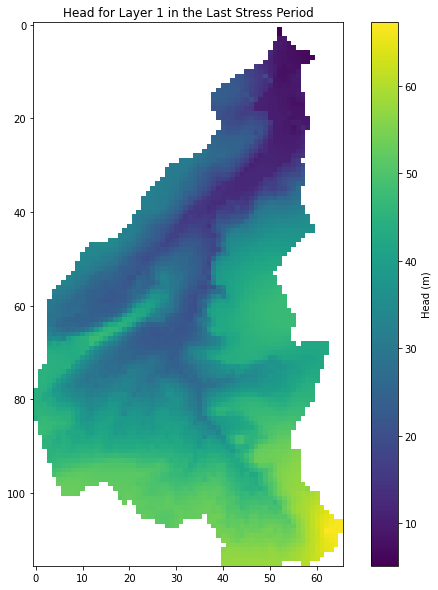

In [3]:
os.chdir('C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_master')
wd='C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_master'
# Load the head data
hds = flopy.utils.HeadFile('Gondebeek.hds')

# Get all times and stress periods/time steps
times = hds.get_times()
kstpkper = hds.get_kstpkper()

# Get the last time and stress period/time step
last_time = times[-1]
last_kstpkper = kstpkper[-1]

# Get the head for the last stress period and time step
head = hds.get_data(totim=last_time)

# Mask values lower than -900
head = np.ma.masked_where(head > 50000, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[1, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()

hds.close()

The number of rows is 32
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package drn...
    loading package riv...
    loading package rch...
    loading package sto...
    loading package ic...
    loading package oc...
    loading package npf...
  loading solution package gondebeek...


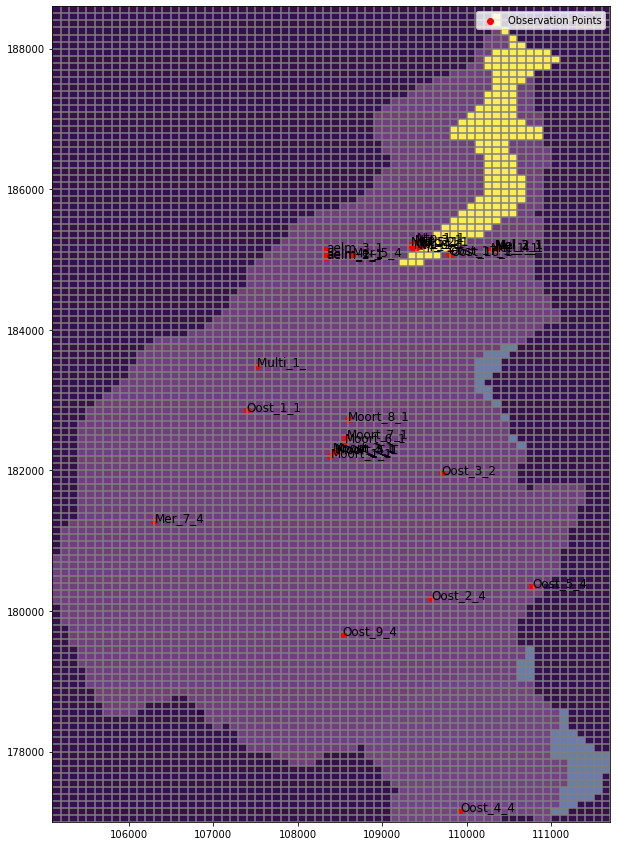

In [4]:
# Load the data
data_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Obs\Standarized_data_in_catchment.csv"
model_path= r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Gondebeek" 
df = pd.read_csv(data_path)

# Drop the rows where 'Layer' is empty
df = df.dropna(subset=['Layer'])

num_rows = df.shape[0]
print(f'The number of rows is {num_rows}')

# Load the MODFLOW 6 model
model = flopy.mf6.MFSimulation.load(sim_name='Gondebeek',sim_ws=wd)

# Get the groundwater flow model from the simulation
gwf = model.get_model('Gondebeek')

# Get the model's discretization package
dis = gwf.dis

# Get the NPF package
npf = gwf.get_package('npf')

# Get the hydraulic conductivity array
k = npf.k.array

# Scatter plot of observation points
fig, ax = plt.subplots(figsize=(10, 15))
modelmap = flopy.plot.PlotMapView(model=gwf, layer=0, ax=ax)
grid = modelmap.plot_grid()
ibound = modelmap.plot_ibound()

# Plot the k values of layer 1
k_layer1 = modelmap.plot_array(k[0], alpha=0.5, cmap='viridis')

# Scatter plot of observation points
scatter = ax.scatter(df['X'], df['Y'], color='red', label='Observation Points')

# Annotate each point with its "Name" and "Layer" attributes
for i in range(df.shape[0]):
    name = df['ID'].iloc[i]
    layer = df['Layer'].iloc[i]
    ax.annotate(f'{name}_{layer}', (df['X'].iloc[i], df['Y'].iloc[i]), fontsize=12)  # Adjust fontsize as needed

# Show the plot
plt.legend()
plt.show()

In [5]:
# Get the unique values of k_layer1
unique_k_values = np.unique(k[3])

# Print the unique values
print(unique_k_values)

[1.5991103e-03 5.7483730e-03 1.0000000e+00 6.5627900e+00 1.1600340e+02]


In [6]:
# Get the hydraulic conductivity array
k = gwf.npf.k.array

# Create a function to get the K value at a specific location
def get_k_at_location(x, y, layer):
    try:
        layer = int(layer) - 1  # Subtract 1 from layer
        row, col = gwf.modelgrid.intersect(x, y)  # Convert x, y to row, col
        return k[layer, int(row), int(col)]
    except ValueError:  # If layer can't be converted to an integer
        return np.nan  # Return a default value

# Create a new DataFrame with the observation points and the K values
df_k = df[['ID', 'X', 'Y', 'Layer']].copy()
df_k['K'] = df.apply(lambda row: get_k_at_location(row['X'], row['Y'], row['Layer']), axis=1)

# Filter out rows where 'Layer' cannot be converted to an integer
df_k = df_k[df_k['K'].notna()]

df_k.head()

,ID,X,Y,Layer,K
0,aelm_1,108334.1,185049.1,1,0.001
1,aelm_2,108334.0,185038.0,1,0.001
2,aelm_3,108334.8,185134.7,1,0.001
5,Mel_1,110287.0,185136.0,1,0.001
6,Mel_2,110344.0,185170.0,1,0.001


In [7]:
# Filter out rows where 'Layer' cannot be converted to an integer
df_filtered = df[pd.to_numeric(df['Layer'], errors='coerce').notna()]


# Save the 'ID', 'X', 'Y', and 'Layer' columns to a text file
df_filtered[['ID', 'X', 'Y', 'Layer']].to_csv('bore_coord.dat', sep='\t', header=False, index=False)



In [8]:
# Define the source and destination paths
source_path = r"C:\Users\sebas\Documents\UGent\Sem 3\Thesis\GondebeekModel\Inputs\Obs\Water_Level\observed_PEST.smp"
destination_path = r"observed_PEST.smp"

# Copy the file
shutil.copy2(source_path, destination_path)

'observed_PEST.smp'

In [9]:


# Get the number of layers
nlay = gwf.modelgrid.nlay

# Create an empty 3D array for the zones
zones = np.zeros((nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=int)

# Initialize a dictionary to store the K values for each zone
zone_k_values = {}

zone_counter = 1
for layer in range(k.shape[0]):
    unique_k_values = np.unique(k[layer])
    for k_value in unique_k_values:
        zones[layer][k[layer] == k_value] = zone_counter
        zone_k_values[zone_counter] = k_value  # Store the K value for the zone
        zone_counter += 1

    # Save the zones for the current layer to a text file
    np.savetxt('zones_layer{}.txt'.format(layer+1), zones[layer], fmt='%d')
    
    


Load the model and write it as external files

In [10]:



# model.set_all_data_external()
# # Get the hydraulic conductivity array from the NPF package


# # Save the hydraulic conductivity arrays to external files
# k_filenames = ["k_layer{}.txt".format(i+1) for i in range(k.shape[0])]
# for layer in range(k.shape[0]):
#     np.savetxt(k_filenames[layer], k[layer])

# # Remove the existing NPF package
# gwf.remove_package('npf')

# # Create a new NPF package that references the external K files
# npf = flopy.mf6.ModflowGwfnpf(gwf, k=k_filenames)

# npf.write(ext_file_action=k_filenames)

# model.write_simulation()

Since DRN and RIV are the ame for all stress periods, we will just keep the first stress period info (if not too much files)

In [11]:
# Define the package file name
package_file = 'Gondebeek.drn'  # replace with your package file name

# Read the package file
with open(package_file, 'r') as file:
    lines = []
    for line in file:
        lines.append(line)
        if line.strip() == 'END period  1':
            break

# Write the modified lines back to the package file
with open(package_file, 'w') as file:
    file.writelines(lines)

# Delete all files that are not 'Gondebeek.drn_stress_period_data_1.txt'
for file in glob.glob('Gondebeek.drn_stress_period_data_*.txt'):
    if file != 'Gondebeek.drn_stress_period_data_1.txt':
        os.remove(file)

In [12]:
# Define the package file name
package_file = 'Gondebeek.riv'  # replace with your package file name

# Read the package file
with open(package_file, 'r') as file:
    lines = []
    for line in file:
        lines.append(line)
        if line.strip() == 'END period  1':
            break

# Write the modified lines back to the package file
with open(package_file, 'w') as file:
    file.writelines(lines)

# Delete all files that are not 'Gondebeek.drn_stress_period_data_1.txt'
for file in glob.glob('Gondebeek.riv_stress_period_data_*.txt'):
    if file != 'Gondebeek.riv_stress_period_data_1.txt':
        os.remove(file)

Create TPL files for K. Only for the zones inside the IBOUND.

In [13]:
# ################################## OLD ONE WITHOUT ZONIFICATION ############################################
# # Get the number of layers
# nlay = gwf.modelgrid.nlay

# # Initialize a dictionary to store the K values for each zone
# zone_k_values = {}

# # Initialize a list to store the data for the DataFrame
# data = []

# idomain = gwf.dis.idomain.array
# zone_counter = 1
# tpl_files = []  # List to store the template file names
# for layer in range(k.shape[0]):
#     unique_k_values = np.unique(k[layer])
#     for k_value in unique_k_values:
#         zones[layer][k[layer] == k_value] = zone_counter
#         zone_k_values[zone_counter] = k_value  # Store the K value for the zone
#         data.append([layer+1, zone_counter, k_value])  # Add the data to the list
#         zone_counter += 1

#     # Create a template file for the current layer
#     tpl_filename = 'zones_layer{}.tpl'.format(layer+1)
#     tpl_files.append(tpl_filename)  # Add the file name to the list
#     with open(tpl_filename, 'w') as f:
#         f.write("ptf ~\n")
#         for row in range(zones[layer].shape[0]):
#             for col in range(zones[layer].shape[1]):
#                 if idomain[layer][row][col] == 1:  # If the cell is inside the IDOMAIN
#                     f.write("~{:>10}~ ".format('k'+str(zones[layer][row][col])))  # Write the parameter name
#                 else:  # If the cell is outside the IDOMAIN
#                     f.write("{:>15} ".format("1.00000000E+00"))  # Write the K value
#             f.write("\n")

# # Print the list of template file names
# print(tpl_files)

In [14]:
# Load the model
sim = flopy.mf6.MFSimulation.load(sim_name='Gondebeek')  # Replace 'Gondebeek_SS.nam' with your model name
gwf = sim.get_model('Gondebeek')
os.getcwd()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package drn...
    loading package riv...
    loading package rch...
    loading package sto...
    loading package ic...
    loading package oc...
    loading package npf...
  loading solution package gondebeek...


'C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Modflow_master'

In [35]:
# Get the number of layers
nlay = gwf.modelgrid.nlay
k=gwf.npf.k.array
# Initialize a dictionary to store the K values for each zone
zone_k_values = {}

# Initialize a list to store the data for the DataFrame
data = []

idomain = gwf.dis.idomain.array
zone_counter = 1
tpl_files = []  # List to store the template file names

for layer in range(k.shape[0]):
    unique_k_values = np.unique(k[layer])
    print(unique_k_values)
    for k_value in unique_k_values:
        if k_value == 1:  # If the K value is 1
            continue  # Skip the current iteration
            
        if layer == 0 and k_value <= 0.001:  # If it's the first layer and the K value is 1.0
            # Apply your zonification logic here
            # For example, divide the layer into three zones based on a sine function
            for row in range(zones[layer].shape[0]):
                for col in range(zones[layer].shape[1]):
                    if k[layer][row, col] == 1.0:  # If the K value is 1.0
                        # Calculate the y-coordinate of the first curve
                        curve1 = 0.1*np.sin(col / zones[layer].shape[1] * 2 * np.pi) * zones[layer].shape[0] / 3 + 1.2*zones[layer].shape[0] / 3
                        # Calculate the y-coordinate of the second curve
                        curve2 = 0.3*np.sin(col / zones[layer].shape[1] * 2 * np.pi) * zones[layer].shape[0] / 3 + 2.75 * zones[layer].shape[0] / 3
                        print(f"Row: {row}, Curve1: {curve1}, Curve2: {curve2}")  # Print the values
                        # Assign the zone based on the y-coordinate of the cell
                        if row < curve1:
                            zones[layer][row, col] = 1
                        elif row < curve2:
                            zones[layer][row, col] = 2
                        else:
                            zones[layer][row, col] = 3

            zone_k_values[zone_counter] = k_value  # Store the K value for the zone
            zone_k_values[zone_counter + 1] = k_value  # Store the K value for the zone
            zone_k_values[zone_counter + 2] = k_value  # Store the K value for the zone
            zone_counter += 3  # Increment the zone_counter by 3
        elif layer == 0 and k_value == 0.34356940:
            zones[layer][k[layer] == k_value]=3
            zone_counter=+1
        elif layer == 0 and k_value == 5.02671100:
            zones[layer][k[layer] == k_value]=4
            zone_counter=4
        elif layer == 0 and k_value == 19.35667000:
            zones[layer][k[layer] == k_value]=5
            zone_counter=5
        elif layer == 1 and k_value == 0.53349570:  # If it's the second layer and the K value is 0.533
            zones[layer][k[layer] == k_value]=6
            zone_counter=6
        elif layer == 1 and k_value == 0.00100000:  # If it's the second layer and the K value is 0.001
            zones[layer][k[layer] == k_value]=7
            zone_counter=7
        elif layer == 1 and k_value == 6.34957100:  # If it's the second layer and the K value is 6.350
            zones[layer][k[layer] == k_value]=8
            zone_counter=8
        elif layer == 2 and k_value == 2.26227300:  # If it's the third layer and the K value is 2.262
            zones[layer][k[layer] == k_value]=9
            zone_counter=9
        elif layer == 2 and k_value == 0.08000079:  # If it's the third layer and the K value is 0.080
            zones[layer][k[layer] == k_value]=10
            zone_counter=10
        elif layer == 2 and k_value == 0.001:  # If it's the third layer and the K value is 0.001
            zones[layer][k[layer] == k_value]=11
            zone_counter=11
        elif layer == 2 and k_value == 2.28077100:  # If it's the third layer and the K value is 2.281
            zones[layer][k[layer] == k_value]=12
            zone_counter=12
        elif layer == 3 and k_value == 116.00340000:  # If it's the fourth layer
            zones[layer][k[layer] == k_value]=13
            zone_counter=13
        elif layer == 3 and k_value == 6.5627900000:
            zones[layer][k[layer] == k_value]=14
            zone_counter=14
        elif layer == 3 and k_value == .00159911030:
            zones[layer][k[layer] == k_value]=15
            zone_counter=15
        elif layer == 3 and k_value == .00574837300:
            zones[layer][k[layer] == k_value]=16
            zone_counter=16 
        
        zone_k_values[zone_counter] = k_value  # Store the K value for the zone
        data.append([layer+1, zone_counter, k_value])  # Add the data to the list


    # Create a template file for the current layer
    tpl_filename = 'zones_layer{}.tpl'.format(layer+1)
    tpl_files.append(tpl_filename)  # Add the file name to the list
    with open(tpl_filename, 'w') as f:
        f.write("ptf ~\n")
        for row in range(zones[layer].shape[0]):
            for col in range(zones[layer].shape[1]):
                if idomain[layer][row][col] == 1:  # If the cell is inside the IDOMAIN
                    f.write("~{:>10}~ ".format('k'+str(zones[layer][row][col])))  # Write the parameter name
                else:  # If the cell is outside the IDOMAIN
                    f.write("{:>15} ".format("1.00000000E+00"))  # Write the K value
            f.write("\n")

[1.000000e-03 3.435694e-01 1.000000e+00 5.026711e+00 1.935667e+01]
Row: 0, Curve1: 46.4, Curve2: 106.33333333333333
Row: 0, Curve1: 46.767550034109505, Curve2: 107.43598343566185
Row: 0, Curve1: 47.131771478193585, Curve2: 108.52864776791408
Row: 0, Curve1: 47.48936588645353, Curve2: 109.6014309926939
Row: 0, Curve1: 47.83709482855326, Curve2: 110.64461781899313
Row: 0, Curve1: 48.17180921734599, Curve2: 111.64876098537128
Row: 0, Curve1: 48.49047782749498, Curve2: 112.60476681581827
Row: 0, Curve1: 48.79021474671967, Curve2: 113.50397757349235
Row: 0, Curve1: 49.06830551106417, Curve2: 114.33824986652583
Row: 0, Curve1: 49.322231687503134, Curve2: 115.10002839584273
Row: 0, Curve1: 49.549693681261296, Curve2: 115.78241437711722
Row: 0, Curve1: 49.74863156129983, Curve2: 116.37922801723282
Row: 0, Curve1: 49.9172437153708, Curve2: 116.88506447944575
Row: 0, Curve1: 50.05400316569672, Curve2: 117.29534283042348
Row: 0, Curve1: 50.157671397517696, Curve2: 117.6063475258864
Row: 0, Curve1

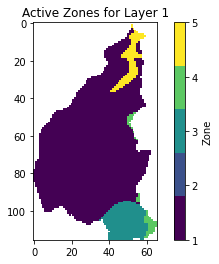

['zones_layer1.tpl', 'zones_layer2.tpl', 'zones_layer3.tpl', 'zones_layer4.tpl']


In [36]:
import matplotlib.colors as colors
import matplotlib.ticker as ticker

# After all the processing, mask the zones with the idomain
zones_masked = np.ma.masked_where(idomain[0] == 0, zones[0
                                                         ])

# Create a discrete colorbar
bounds = np.linspace(np.min(zones_masked), np.max(zones_masked), np.max(zones_masked) - np.min(zones_masked) + 2)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# Plot the masked zones for layer 1
fig, ax = plt.subplots()
img = ax.imshow(zones_masked, cmap='viridis', interpolation='none', norm=norm)

# Create a colorbar
cbar = fig.colorbar(img, ax=ax, ticks=ticker.MaxNLocator(integer=True))
cbar.set_label('Zone')

plt.title('Active Zones for Layer 1')
plt.show()
# Print the list of template file names
print(tpl_files)

In [16]:
print(zone_k_values)

for zone, k_value in zone_k_values.items():
    print(f'Zone {zone}: K value = {k_value}')

{1: 0.001, 2: 0.001, 3: 1.0, 4: 5.026711, 5: 19.35667, 7: 0.001, 6: 1.0, 8: 6.349571, 11: 0.001, 10: 1.0, 9: 2.262273, 12: 2.280771, 15: 0.0015991103, 16: 1.0, 14: 6.56279, 13: 116.0034}
Zone 1: K value = 0.001
Zone 2: K value = 0.001
Zone 3: K value = 1.0
Zone 4: K value = 5.026711
Zone 5: K value = 19.35667
Zone 7: K value = 0.001
Zone 6: K value = 1.0
Zone 8: K value = 6.349571
Zone 11: K value = 0.001
Zone 10: K value = 1.0
Zone 9: K value = 2.262273
Zone 12: K value = 2.280771
Zone 15: K value = 0.0015991103
Zone 16: K value = 1.0
Zone 14: K value = 6.56279
Zone 13: K value = 116.0034


In [37]:
# Get the number of layers
nlay = gwf.modelgrid.nlay

# Get the hydraulic conductivity array
ss = gwf.sto.ss.array
sy = gwf.sto.sy.array
# Initialize a dictionary to store the S values for each zone
zone_ss_values = {}

# Initialize a list to store the data for the DataFrame
data = []
# Initialize zones as a 3D array filled with zeros
zones = np.zeros_like(ss)
idomain = gwf.dis.idomain.array
zone_counter = 1
tpl_files_ss = []  # List to store the template file names

for layer in range(ss.shape[0]):
    unique_ss_values = np.unique(ss[layer])
    for ss_value in unique_ss_values:
        if layer == 0 and ss_value == 0.001:  # If it's the first layer and the K value is 1.0
            # Apply your zonification logic here
            # For example, divide the layer into three zones based on a sine function
            for row in range(zones[layer].shape[0]):
                for col in range(zones[layer].shape[1]):
                    if ss[layer][row, col] == 0.009:  # If the K value is 1.0
                        # Calculate the y-coordinate of the first curve
                        curve1 = 0.1*np.sin(col / zones[layer].shape[1] * 2 * np.pi) * zones[layer].shape[0] / 3 + 1.2*zones[layer].shape[0] / 3
                        # Calculate the y-coordinate of the second curve
                        curve2 = 0.3*np.sin(col / zones[layer].shape[1] * 2 * np.pi) * zones[layer].shape[0] / 3 + 2.75 * zones[layer].shape[0] / 3
                        # Assign the zone based on the y-coordinate of the cell
                        if row < curve1:
                            zones[layer][row, col] = zone_counter
                        elif row < curve2:
                            zones[layer][row, col] = zone_counter + 1
                        else:
                            zones[layer][row, col] = zone_counter + 2
            zone_ss_values[zone_counter] = ss_value  # Store the S value for the zone
            zone_ss_values[zone_counter + 1] = ss_value  # Store the S value for the zone
            zone_ss_values[zone_counter + 2] = ss_value  # Store the S value for the zone
            zone_counter += 3
        else:
            zones[layer][ss[layer] == ss_value] = zone_counter
            zone_ss_values[zone_counter] = ss_value  # Store the S value for the zone
            zone_counter += 1
        zone_ss_values[zone_counter] = ss_value  # Store the S value for the zone
        data.append([layer+1, zone_counter, ss_value])  # Add the data to the list

    tpl_filename_ss = 'zones_ss_layer{}.tpl'.format(layer+1)
    tpl_files.append(tpl_filename_ss)  # Add the file name to the list
    with open(tpl_filename_ss, 'w') as f:
        f.write("ptf ~\n")
        for row in range(zones[layer].shape[0]):
            for col in range(zones[layer].shape[1]):
                if idomain[layer][row][col] == 1:  # If the cell is inside the IDOMAIN
                    f.write("~{:>10}~ ".format('ss'+str(zones[layer][row][col])))  # Write the parameter name
                else:  # If the cell is outside the IDOMAIN
                    f.write("{:>15} ".format("1.00000000E+00"))  # Write the s value
            f.write("\n")


zone_sy_values = {}
# Initialize a list to store the data for the DataFrame
data = []
# Initialize zones as a 3D array filled with zeros
zones = np.zeros_like(ss)
idomain = gwf.dis.idomain.array
zone_counter = 1
tpl_files_ss = []  # List to store the template file names
tpl_files_sy = []

for layer in range(ss.shape[0]):
    unique_sy_values = np.unique(sy[layer])
    for sy_value in unique_sy_values:
        if layer == 0 and sy_value == 0.005:  # If it's the first layer and the K value is 1.0
            # Apply your zonification logic here
            # For example, divide the layer into three zones based on a sine function
            for row in range(zones[layer].shape[0]):
                for col in range(zones[layer].shape[1]):
                    if sy[layer][row, col] == 0.05:  # If the K value is 1.0
                        # Calculate the y-coordinate of the first curve
                        curve1 = 0.1*np.sin(col / zones[layer].shape[1] * 2 * np.pi) * zones[layer].shape[0] / 3 + 1.2*zones[layer].shape[0] / 3
                        # Calculate the y-coordinate of the second curve
                        curve2 = 0.3*np.sin(col / zones[layer].shape[1] * 2 * np.pi) * zones[layer].shape[0] / 3 + 2.75 * zones[layer].shape[0] / 3
                        # Assign the zone based on the y-coordinate of the cell
                        if row < curve1:
                            zones[layer][row, col] = zone_counter
                        elif row < curve2:
                            zones[layer][row, col] = zone_counter + 1
                        else:
                            zones[layer][row, col] = zone_counter + 2
            zone_sy_values[zone_counter] = sy_value  # Store the S value for the zone
            zone_sy_values[zone_counter + 1] = sy_value  # Store the S value for the zone
            zone_sy_values[zone_counter + 2] = sy_value  # Store the S value for the zone
            zone_counter += 3
        else:
            zones[layer][sy[layer] == sy_value] = zone_counter
            zone_sy_values[zone_counter] = sy_value  # Store the S value for the zone
            zone_counter += 1
        zone_sy_values[zone_counter] = sy_value  # Store the S value for the zone
        data.append([layer+1, zone_counter, sy_value])  # Add the data to the list

    tpl_filename_sy = 'zones_sy_layer{}.tpl'.format(layer+1)
    tpl_files.append(tpl_filename_sy)  # Add the file name to the list
    with open(tpl_filename_sy, 'w') as f:
        f.write("ptf ~\n")
        for row in range(zones[layer].shape[0]):
            for col in range(zones[layer].shape[1]):
                if idomain[layer][row][col] == 1:  # If the cell is inside the IDOMAIN
                    f.write("~{:>10}~ ".format('sy'+str(zones[layer][row][col])))  # Write the parameter name
                else:  # If the cell is outside the IDOMAIN
                    f.write("{:>15} ".format("1.00000000E+00"))  # Write the s value
            f.write("\n")


import matplotlib.colors as colors
import matplotlib.ticker as ticker



# After all the processing, mask the zones with the idomain
zones_masked = np.ma.masked_where(idomain[0] == 0, zones[0])

# Check if there is more than one unique value in zones_masked
if np.min(zones_masked) != np.max(zones_masked):
    # Create a discrete colorbar
    bounds = np.linspace(np.min(zones_masked), np.max(zones_masked), int(np.max(zones_masked) - np.min(zones_masked) + 1))
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

    # Plot the masked zones for layer 1
    fig, ax = plt.subplots()
    img = ax.imshow(zones_masked, cmap='viridis', interpolation='none', norm=norm)

    # Create a colorbar
    cbar = fig.colorbar(img, ax=ax, ticks=ticker.MaxNLocator(integer=True))
    cbar.set_label('Zone')

    plt.title('Active Zones for Layer 1')
    plt.show()
else:
    print("All values in zones_masked are the same, cannot create colorbar and plot.")

# Print the list of template file names

print(tpl_files)

All values in zones_masked are the same, cannot create colorbar and plot.
['zones_layer1.tpl', 'zones_layer2.tpl', 'zones_layer3.tpl', 'zones_layer4.tpl', 'zones_ss_layer1.tpl', 'zones_ss_layer2.tpl', 'zones_ss_layer3.tpl', 'zones_ss_layer4.tpl', 'zones_sy_layer1.tpl', 'zones_sy_layer2.tpl', 'zones_sy_layer3.tpl', 'zones_sy_layer4.tpl']


In [38]:
print(zone_ss_values)

for zone, s_value in zone_ss_values.items():
    print(f'Zone {zone}: K value = {s_value}')

print(zone_sy_values)

for zone, s_value in zone_sy_values.items():
    print(f'Zone {zone}: K value = {s_value}')

{1: 0.009, 2: 1e-05, 3: 9.9999998e-05, 4: 0.009, 5: 1e-05, 6: 0.009, 7: 1e-05, 8: 0.009, 9: 0.009}
Zone 1: K value = 0.009
Zone 2: K value = 1e-05
Zone 3: K value = 9.9999998e-05
Zone 4: K value = 0.009
Zone 5: K value = 1e-05
Zone 6: K value = 0.009
Zone 7: K value = 1e-05
Zone 8: K value = 0.009
Zone 9: K value = 0.009
{1: 0.05, 2: 0.05, 3: 0.05, 4: 0.05, 5: 0.05}
Zone 1: K value = 0.05
Zone 2: K value = 0.05
Zone 3: K value = 0.05
Zone 4: K value = 0.05
Zone 5: K value = 0.05


In [39]:
import matplotlib.colors as colors
import matplotlib.ticker as ticker

# After all the processing, mask the zones with the idomain
zones_masked = np.ma.masked_where(idomain[0] == 0, zones[0
                                                         ])

# Create a discrete colorbar
bounds = np.linspace(np.min(np.int(zones_masked)), np.max(zones_masked), np.max(zones_masked) - np.min(zones_masked) + 2)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# Plot the masked zones for layer 1
fig, ax = plt.subplots()
img = ax.imshow(zones_masked, cmap='viridis', interpolation='none', norm=norm)

# Create a colorbar
cbar = fig.colorbar(img, ax=ax, ticks=ticker.MaxNLocator(integer=True))
cbar.set_label('Zone')

plt.title('Active Zones for Layer 1')
plt.show()
# Print the list of te

TypeError: 'numpy.float64' object cannot be interpreted as an integer

Create TPL file for the River package (conductance)

In [19]:
def create_tpl_file(original_file, tpl_file,replacetxt,):
    # Read the original file
    with open(original_file, 'r') as f:
        lines = f.readlines()

    # Modify the fifth column and write to the template file
    with open(tpl_file, 'w') as f:
        f.write("ptf ~\n")  # Write the parameter transformation flag
        for line in lines:
            parts = line.split()
            parts[4] = replacetxt  # Replace the fifth column
            f.write(' '.join(parts) + '\n')

    # Add the template file to the list
    tpl_files.append(tpl_file)

# Use the function to create the template file
create_tpl_file('Gondebeek.riv_stress_period_data_1.txt', 'riv.tpl',"~        c~")

print(tpl_files)

['zones_layer1.tpl', 'zones_layer2.tpl', 'zones_layer3.tpl', 'zones_layer4.tpl', 'zones_ss_layer1.tpl', 'zones_ss_layer2.tpl', 'zones_ss_layer3.tpl', 'zones_ss_layer4.tpl', 'zones_sy_layer1.tpl', 'zones_sy_layer2.tpl', 'zones_sy_layer3.tpl', 'zones_sy_layer4.tpl', 'riv.tpl']


Create TPL for drain package (conductance)

In [20]:
# Use the function to create the template file
create_tpl_file('Gondebeek.drn_stress_period_data_1.txt', 'drn.tpl',"~        c2~")

print(tpl_files)

['zones_layer1.tpl', 'zones_layer2.tpl', 'zones_layer3.tpl', 'zones_layer4.tpl', 'zones_ss_layer1.tpl', 'zones_ss_layer2.tpl', 'zones_ss_layer3.tpl', 'zones_ss_layer4.tpl', 'zones_sy_layer1.tpl', 'zones_sy_layer2.tpl', 'zones_sy_layer3.tpl', 'zones_sy_layer4.tpl', 'riv.tpl', 'drn.tpl']


Create INS file for the observation.smp

In [21]:
# Read the 'simulated.smp' file
df2 = pd.read_csv('observed_PEST.smp', sep='\s+', header=None)

# Extract the observation IDs and values
obs_ids = df2[0].tolist()
values = df2[3].tolist()

# Open the TPL file
with open('simulated.smp.tpl', 'w') as f:
    # Write the PIF line
    f.write('pif ~\n')

    # Write the observation IDs and values
    for obs_id, value in zip(obs_ids, values):
        f.write('l1   [HEAD_{}]55:66\n'.format(obs_id))

print("TPL file 'simulated_PEST.smp.tpl' created.")

TPL file 'simulated_PEST.smp.tpl' created.


<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
C:\Users\sebas\AppData\Local\Temp\ipykernel_20956\1669845584.py:2: DeprecationWarning: invalid escape sequence \s
  df2 = pd.read_csv('observed_PEST.smp', sep='\s+', header=None)


Creation of neccesary PEST files with PEST_utils (do not run every time!!)

In [22]:
#instruction file for mf6mod2obs
#instruction_file = PEST_utils.mf6mod2obs_in(os.getcwd(), 'file.ntb','observed.smp' , 'Gondebeek_SS.hds', 's', gwf.dis.nlay.data, 'd', '01-01-2015', 10, 'simulated.smp')


# Delete the 'run_model.bat' file if it exists
if os.path.exists('run_model.bat'):
    os.remove('run_model.bat')

# Use the function to add instructions to the batch file
PEST_utils.addbatchfile(os.getcwd(), '@echo off', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'del Gondebeek_SS.hds', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'del Gondebeek_SS.cbc', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'mf6.exe Gondebeek_SS.nam', 'run_model.bat')
PEST_utils.addbatchfile(os.getcwd(), 'mf6mod2obs < simulated.in', 'run_model.bat')



'run_model.bat'

In [23]:
pst=PEST_utils.pestprep1(os.getcwd(),'gondebeek.pst', 'observed_PEST.smp', 'simulated_PEST.smp','','head', tpl_files, 'run_model.bat')

From this line now on are the results

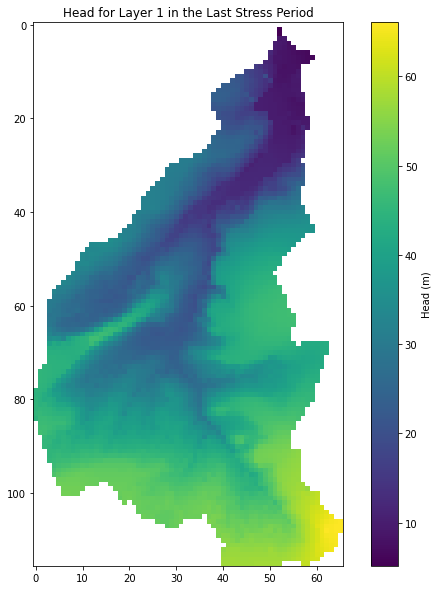

In [2]:
result_ws='C:/Users/sebas/Documents/UGent/Sem 3/Thesis/GondebeekModel/Modflow_master'

# Load the head data
hds = flopy.utils.HeadFile(os.path.join(result_ws,'Gondebeek.hds'))

# Get all times and stress periods/time steps
times = hds.get_times()
kstpkper = hds.get_kstpkper()

# Get the last time and stress period/time step
last_time = times[-1]
last_kstpkper = kstpkper[-1]

# Get the head for the last stress period and time step
head = hds.get_data(totim=last_time)

# Mask values greater than 200
head = np.ma.masked_where(head > 1e29, head)

# Plot the head for layer 1
plt.figure(figsize=(10, 10))
plt.imshow(head[1, :, :], cmap='viridis', interpolation='none')
plt.colorbar(label='Head (m)')
plt.title('Head for Layer 1 in the Last Stress Period')
plt.show()
hds.close()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package drn...
    loading package riv...
    loading package rch...
    loading package sto...
    loading package ic...
    loading package oc...
    loading package npf...
  loading solution package gondebeek...


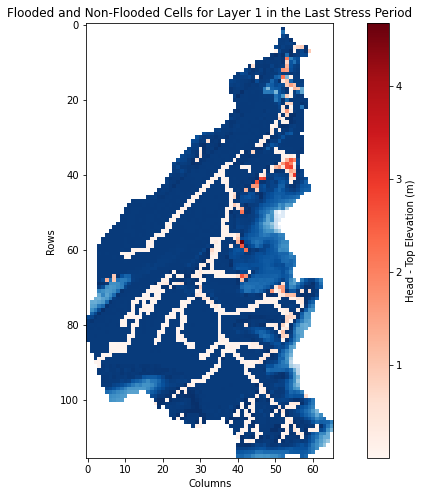

In [3]:
# Load the model
sim = flopy.mf6.MFSimulation.load(sim_name='Gondebeek', sim_ws=result_ws)  # Replace 'Gondebeek_SS.nam' with your model name
gwf = sim.get_model('Gondebeek')

# Get the top elevation of the cells
top = gwf.dis.top.array

# Calculate the difference between the head and the top elevation
diff = head[1, :, :] - top

# Create a mask for the flooded cells (where the difference is positive)
flooded = np.ma.masked_where(diff <= 0, diff)

# Create a mask for the non-flooded cells (where the difference is zero or negative)
non_flooded = np.ma.masked_where(diff > 0, diff)

# Create a subplot
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the size if needed

# Plot the non-flooded cells in blue and the flooded cells in red
im_nf = ax.imshow(non_flooded, cmap='Blues', interpolation='none')
im_f = ax.imshow(flooded, cmap='Reds', interpolation='none')

# Add a colorbar to the subplot
cbar = fig.colorbar(im_f, ax=ax, label='Head - Top Elevation (m)')

ax.set_title('Flooded and Non-Flooded Cells for Layer 1 in the Last Stress Period')
ax.set_xlabel('Columns')  # Add your X-axis label here
ax.set_ylabel('Rows')  # Add your Y-axis label here


# Get the last part of the result_ws string
folder_name = os.path.basename(result_ws)

# Create the filename by adding the string "flooded_cells"
filename = f"{folder_name}_flooded_cells.png"

# Save the figure with adjusted size and higher resolution
plt.savefig(filename, bbox_inches='tight', dpi=300)

# Show the figure (optional)
plt.show()

# Show the figure (optional)
plt.show()

# Close the file (if needed)
hds.close()


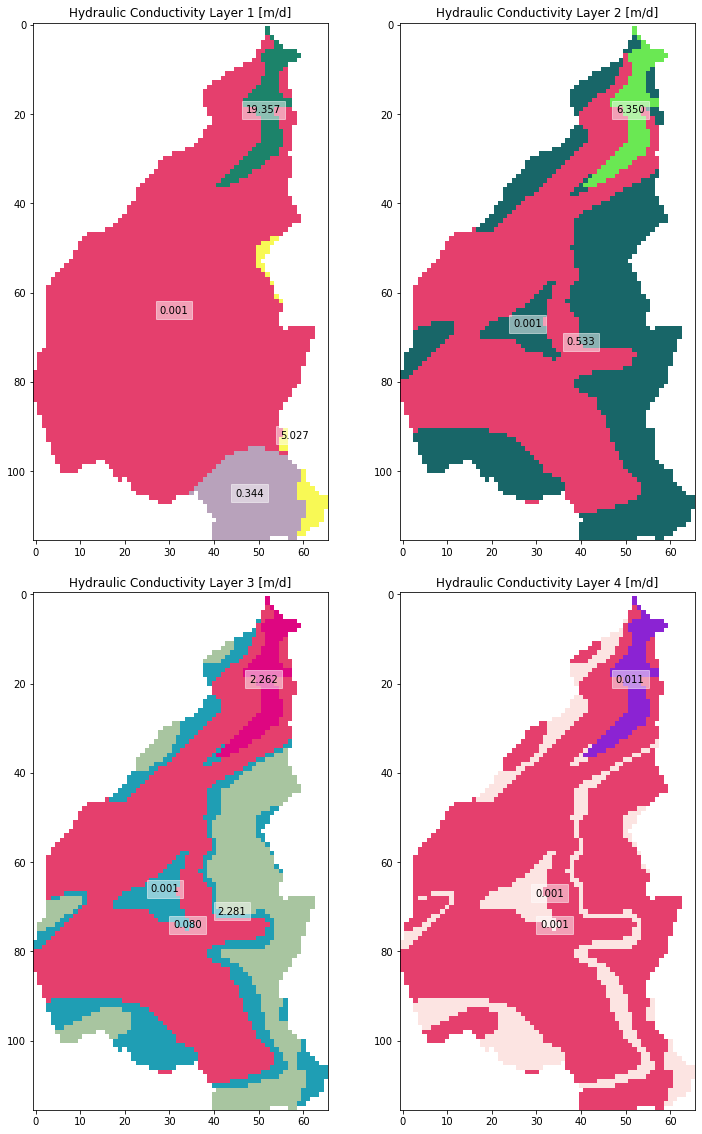

In [4]:
import matplotlib.colors as mcolors
import numpy as np
import random

# Define the workspace and model name
model_ws = result_ws
model_name = 'Gondebeek'



# Get the hydraulic conductivity values
hk = gwf.npf.k.array

# Get the idomain values
idomain = gwf.dis.idomain.array

# Mask the hydraulic conductivity values with the idomain
hk_masked = np.ma.masked_where(idomain == 0, hk)

# Get unique hydraulic conductivity values and assign each a unique random color
unique_hk = np.unique(hk_masked.compressed())  # Use the compressed() method to remove the MaskedConstant values
colors = [np.random.rand(3,) for _ in range(len(unique_hk))]
hk_color_dict = dict(zip(unique_hk, colors))

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=-0.51, hspace=0.1)

# Plot the hydraulic conductivity of each layer
for i, layer in enumerate(hk_masked):
    ax = axs[i//2, i%2]  # Select the current subplot
    color_layer = np.ones((layer.shape[0], layer.shape[1], 3))  # Initialize the color_layer array with ones
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                color_layer[j, k] = hk_color_dict[layer[j, k]]
    ax.imshow(color_layer)
    
    ax.set_title(f'Hydraulic Conductivity Layer {i+1} [m/d]')
    
    # Create a dictionary where each unique hydraulic conductivity value is a key and the corresponding value is a list of coordinates where this hydraulic conductivity value occurs
    hk_coords = {hk: [] for hk in unique_hk}
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                hk_coords[layer[j, k]].append((j, k))
    
    # For each unique hydraulic conductivity value, calculate the center of the corresponding coordinates and display the hydraulic conductivity value at this center
    for hk, coords in hk_coords.items():
        if coords:  # If the list of coordinates is not empty
            center = np.mean(coords, axis=0).astype(int)  # Calculate the center of the coordinates
            ax.text(center[1], center[0], f'{hk:.3f}', ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white'))  # Use three significant digits

# Get the last part of the result_ws string
folder_name = os.path.basename(result_ws)

# Create the filename by adding the string "flooded_cells"
filename = f"{folder_name}_HK_layers.png"

# Save the figure with adjusted size and higher resolution
plt.savefig(filename)

# Show the figure (optional)
plt.show()

Same as above but with obs points

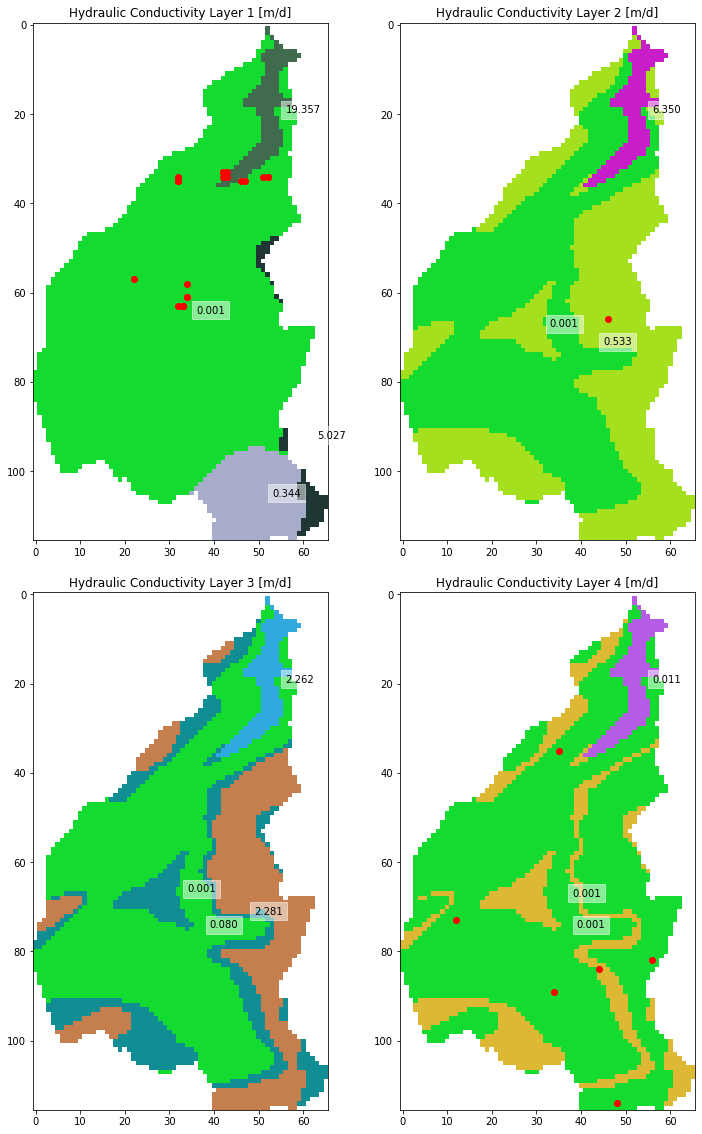

In [13]:
import matplotlib.colors as mcolors
import numpy as np
import random
import pandas as pd


# Get the groundwater flow model
gwf = sim.get_model(model_name)

# Get the hydraulic conductivity values
hk = gwf.npf.k.array

# Get the idomain values
idomain = gwf.dis.idomain.array

# Mask the hydraulic conductivity values with the idomain
hk_masked = np.ma.masked_where(idomain == 0, hk)

# Get unique hydraulic conductivity values and assign each a unique random color
unique_hk = np.unique(hk_masked.compressed())  # Use the compressed() method to remove the MaskedConstant values
colors = [np.random.rand(3,) for _ in range(len(unique_hk))]
hk_color_dict = dict(zip(unique_hk, colors))

# Read the observation points
obs_points = pd.read_csv(model_ws + '/bore_coord.dat', sep='\t', header=None, names=['name', 'x', 'y', 'layer'])

# Convert the x and y coordinates to row and column indices
obs_points['row'] = np.floor((gwf.modelgrid.extent[3] - obs_points['y']) / gwf.modelgrid.delc[0]).astype(int)
obs_points['col'] = np.floor((obs_points['x'] - gwf.modelgrid.extent[0]) / gwf.modelgrid.delr[0]).astype(int)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=-0.51, hspace=0.1)
# Plot the hydraulic conductivity of each layer
for i, layer in enumerate(hk_masked):
    ax = axs[i//2, i%2]  # Select the current subplot
    color_layer = np.ones((layer.shape[0], layer.shape[1], 3))  # Initialize the color_layer array with ones
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                color_layer[j, k] = hk_color_dict[layer[j, k]]
    ax.imshow(color_layer)
    
    ax.set_title(f'Hydraulic Conductivity Layer {i+1} [m/d]')
    
    # Create a dictionary where each unique hydraulic conductivity value is a key and the corresponding value is a list of coordinates where this hydraulic conductivity value occurs
    hk_coords = {hk: [] for hk in unique_hk}
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                hk_coords[layer[j, k]].append((j, k))
    
    # For each unique hydraulic conductivity value, calculate the center of the corresponding coordinates and display the hydraulic conductivity value at this center
    for hk, coords in hk_coords.items():
        if coords:  # If the list of coordinates is not empty
            center = np.mean(coords, axis=0).astype(int)  # Calculate the center of the coordinates
            ax.text(center[1] + 5, center[0], f'{hk:.3f}', ha='left', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white'))  # Use three significant digits

    # Plot the observation points on the current layer
    layer_obs_points = obs_points[obs_points['layer'] == i+1]
    ax.scatter(layer_obs_points['col'], layer_obs_points['row'], color='red')

# Get the last part of the result_ws string
folder_name = os.path.basename(result_ws)

# Create the filename by adding the string "flooded_cells"
filename = f"{folder_name}_HK_layers_obs_points.png"

# Save the figure with adjusted size and higher resolution
plt.savefig(filename)

# Show the figure (optional)
plt.show()

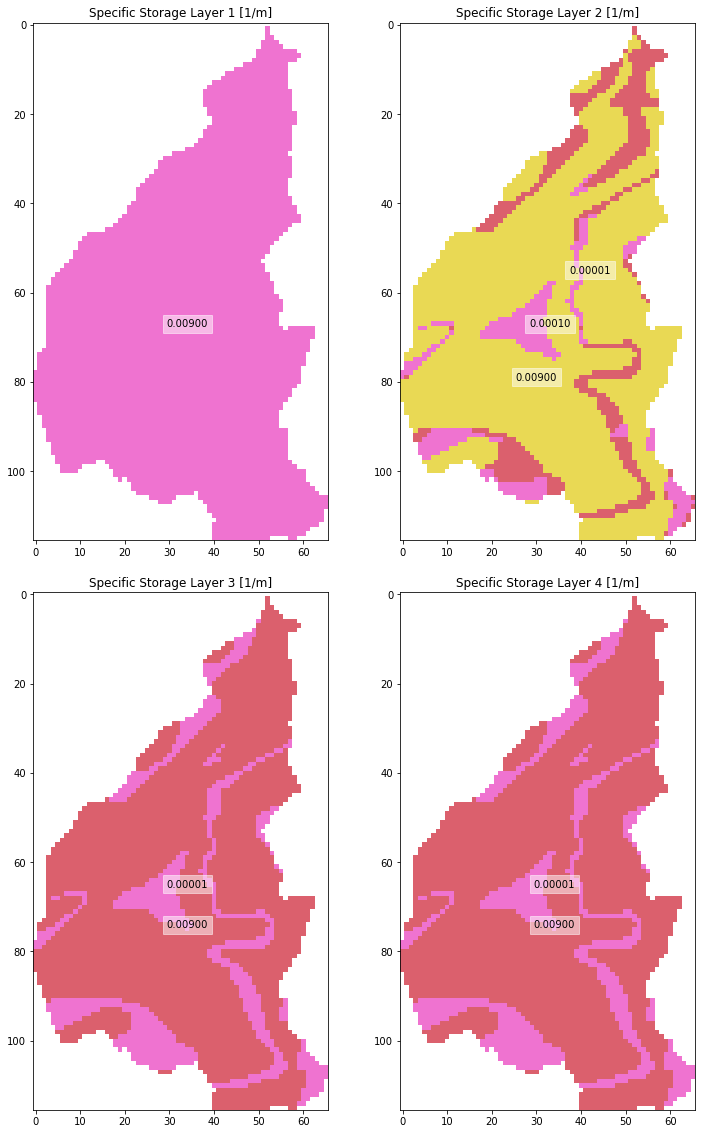

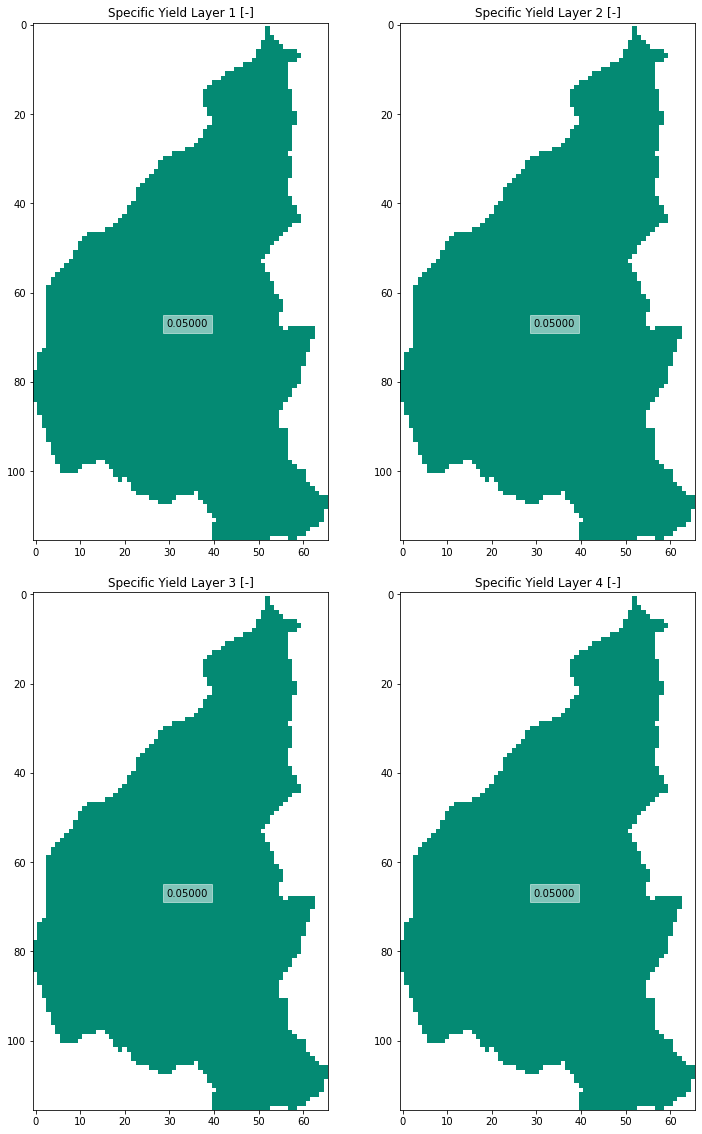

In [18]:
# Get the specific storage and specific yield values
ss = gwf.sto.ss.array
sy = gwf.sto.sy.array

# Mask the specific storage and specific yield values with the idomain
ss_masked = np.ma.masked_where(idomain == 0, ss)
sy_masked = np.ma.masked_where(idomain == 0, sy)

# Get unique specific storage and specific yield values and assign each a unique random color
unique_ss = np.unique(ss_masked.compressed())
unique_sy = np.unique(sy_masked.compressed())
colors_ss = [np.random.rand(3,) for _ in range(len(unique_ss))]
colors_sy = [np.random.rand(3,) for _ in range(len(unique_sy))]
ss_color_dict = dict(zip(unique_ss, colors_ss))
sy_color_dict = dict(zip(unique_sy, colors_sy))

# Create a 2x2 grid of subplots for specific storage
fig_ss, axs_ss = plt.subplots(2, 2, figsize=(20, 20))
plt.subplots_adjust(wspace=-0.51, hspace=0.1)

# Create a 2x2 grid of subplots for specific yield
fig_sy, axs_sy = plt.subplots(2, 2, figsize=(20, 20))
plt.subplots_adjust(wspace=-0.51, hspace=0.1)

# Plot the specific storage of each layer
for i, layer in enumerate(ss_masked):
    ax = axs_ss[i//2, i%2]
    color_layer = np.ones((layer.shape[0], layer.shape[1], 3))
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:
                color_layer[j, k] = ss_color_dict[layer[j, k]]
    ax.imshow(color_layer)
    ax.set_title(f'Specific Storage Layer {i+1} [1/m]')
    
    # Create a dictionary where each unique ss value is a key and the corresponding value is a list of coordinates where this ss value occurs
    ss_coords = {ss: [] for ss in unique_ss}
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                ss_coords[layer[j, k]].append((j, k))
    
    # For each unique ss value, calculate the center of the corresponding coordinates and display the ss value at this center
    for ss, coords in ss_coords.items():
        if coords:  # If the list of coordinates is not empty
            center = np.mean(coords, axis=0).astype(int)  # Calculate the center of the coordinates
            ax.text(center[1], center[0], f'{ss:.5f}', ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white'))  # Use five significant digits

# Plot the specific yield of each layer
for i, layer in enumerate(sy_masked):
    ax = axs_sy[i//2, i%2]
    color_layer = np.ones((layer.shape[0], layer.shape[1], 3))
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:
                color_layer[j, k] = sy_color_dict[layer[j, k]]
    ax.imshow(color_layer)
    ax.set_title(f'Specific Yield Layer {i+1} [-]')
    
    # Create a dictionary where each unique sy value is a key and the corresponding value is a list of coordinates where this sy value occurs
    sy_coords = {sy: [] for sy in unique_sy}
    for j in range(layer.shape[0]):
        for k in range(layer.shape[1]):
            if idomain[i, j, k] != 0:  # Only consider active cells
                sy_coords[layer[j, k]].append((j, k))
    
    # For each unique sy value, calculate the center of the corresponding coordinates and display the sy value at this center
    for sy, coords in sy_coords.items():
        if coords:  # If the list of coordinates is not empty
            center = np.mean(coords, axis=0).astype(int)  # Calculate the center of the coordinates
            ax.text(center[1], center[0], f'{sy:.5f}', ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='white'))  # Use five significant digits

# Save and show the figures
plt.savefig(f"{folder_name}_SS_layers.png")
plt.savefig(f"{folder_name}_SY_layers.png")
plt.show()

## Budget results

In [7]:
# Load the model
sim = flopy.mf6.MFSimulation.load(sim_name='Gondebeek',sim_ws=result_ws)
gwf = sim.get_model('Gondebeek')

# Get the idomain array from the dis package of the model
idomain = gwf.dis.idomain.array

# Create the zone array from the idomain array
zon = np.where(idomain == 0, 1, idomain)

zonbud = gwf.output.zonebudget(zon)
zonbud.change_model_ws(result_ws)
zonbud.write_input()
zonbud.run_model()

df_res = zonbud.get_dataframes(net=True)
df_res = df_res.reset_index()

# Delete the zonbud object


# Print the contents of the CSV file for the last time step and stress period
print(df_res)
print(df_res['name'],df_res['ZONE_1']/86.4)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package drn...
    loading package riv...
    loading package rch...
    loading package sto...
    loading package ic...
    loading package oc...
    loading package npf...
  loading solution package gondebeek...
FloPy is using the following executable to run the model: zbud6.exe
                              ZONEBUDGET Version 6
                             U.S. GEOLOGICAL SURVEY
                            VERSION 6.4.4 02/13/2024
................................................................................................................................................................................................................................................................................................................................................................................................................................

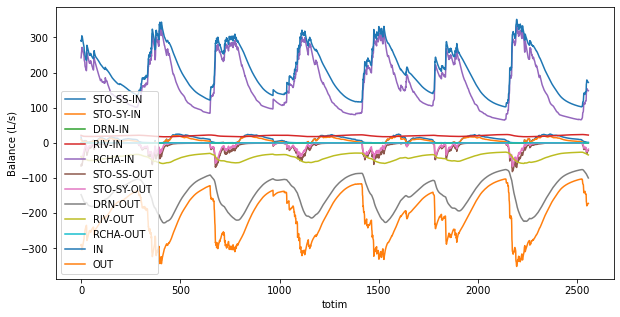

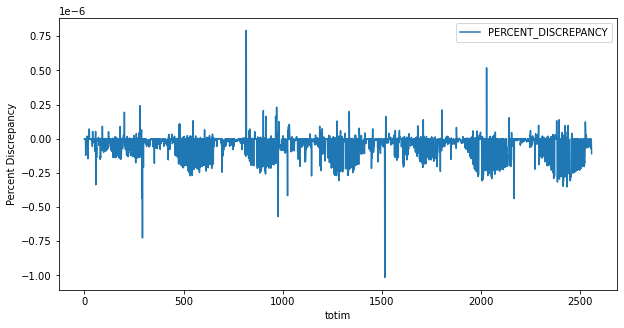

In [19]:
# Load the budget data from the CSV file
budget_df = pd.read_csv('zonebud.csv')

# Make all '-OUT' values negative
for column in budget_df.columns:
    if column.endswith('-OUT'):
        budget_df[column] = -budget_df[column]

# Compute the total inflow and outflow for each time step
budget_df['IN'] = budget_df.filter(regex='-IN$').sum(axis=1)
budget_df['OUT'] = budget_df.filter(regex='-OUT$').sum(axis=1)

# Compute the percent discrepancy
budget_df['PERCENT_DISCREPANCY'] = (budget_df['OUT'] + budget_df['IN']) / budget_df['IN'] * 100

# Select only the "-IN" and "-OUT" terms
budget_df = budget_df.filter(regex='IN$|OUT$|PERCENT_DISCREPANCY')

# Convert the flow values from cubic meters per day to liters per second, excluding the percent discrepancy
for component in budget_df.columns:
    if component != 'PERCENT_DISCREPANCY':
        budget_df[component] = pd.to_numeric(budget_df[component], errors='coerce') / 86.4

# Plot each component of the balances, excluding the "percent discrepancy"
plt.figure(figsize=(10, 5))
for component in budget_df.columns:
    if component != 'PERCENT_DISCREPANCY':
        if len(budget_df.index) == 1:
            plt.scatter(budget_df.index.to_numpy(), budget_df[component].to_numpy(), label=component)
        else:
            plt.plot(budget_df.index.to_numpy(), budget_df[component].to_numpy(), label=component)

# Add a legend
plt.legend()

# Add labels
plt.xlabel('totim')
plt.ylabel('Balance (L/s)')  # Update the y-axis label

# Show the plot
plt.show()

# Show the plot
plt.show()

# Plot the "percent discrepancy" separately
plt.figure(figsize=(10, 5))
if len(budget_df.index) == 1:
    plt.scatter(budget_df.index.to_numpy(), budget_df['PERCENT_DISCREPANCY'].to_numpy(), label='PERCENT_DISCREPANCY')
else:
    plt.plot(budget_df.index.to_numpy(), budget_df['PERCENT_DISCREPANCY'].to_numpy(), label='PERCENT_DISCREPANCY')

# Add a legend
plt.legend()

# Add labels
plt.xlabel('totim')
plt.ylabel('Percent Discrepancy')

# Show the plot
plt.show()

Create a mesh with PyVista

In [8]:

# Create a vtk object
vtkobj = flopy.export.vtk.Vtk(gwf, modelgrid=sim, vertical_exageration=10,binary=False)

# Flatten the entire 3D array of bottom elevations
botm_flattened = gwf.dis.botm.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(botm_flattened, "botm")

# Calculate the top elevations
botm = gwf.dis.botm.array
top = np.empty_like(botm)
top[0] = gwf.dis.top.array
top[1:] = botm[:-1]

# Flatten the entire 3D array of top elevations
top_flattened = top.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(top_flattened, "top")

# Flatten the entire 3D array of hydraulic conductivity
hk_flattened = gwf.npf.k.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(hk_flattened, "k")

# Flatten the entire 3D array of specific storage
ss_flattened = gwf.sto.ss.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(ss_flattened, "ss")

# Flatten the entire 3D array of specific yield
sy_flattened = gwf.sto.sy.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(sy_flattened, "sy")

# Flatten the entire 3D array of ibound
ibound_flattened = gwf.dis.idomain.array.flatten()

# Add the flattened array to the VTK object
vtkobj.add_array(ibound_flattened, "ibound")

# Write the VTK object to a file
vtkobj.write("model.vtk")


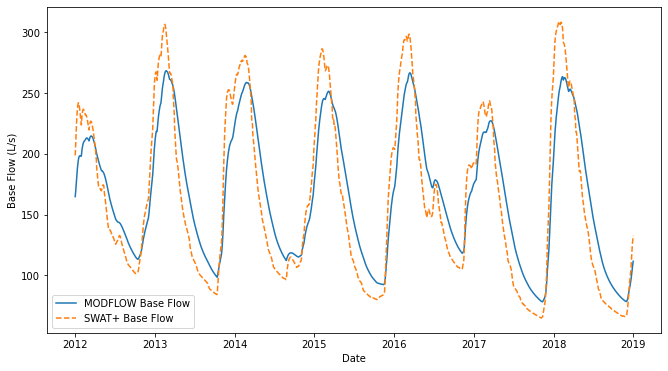

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the base flow from SWAT+
swat_base_flow = pd.read_csv('C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\GondebeekModel\\Inputs\\Recharge\\daily_flow.csv')

# Convert the 'date' column to datetime
swat_base_flow['date'] = pd.to_datetime(swat_base_flow['date'])

# Compute the base flow using absolute values
budget_df['BASE_FLOW'] = budget_df['DRN-OUT'].abs() + budget_df['RIV-OUT'].abs() - budget_df['RIV-IN'].abs()

# Take the absolute value of the result
budget_df['BASE_FLOW'] = budget_df['BASE_FLOW'].abs()

# Save the base flow to a CSV file
budget_df['BASE_FLOW'].to_csv('base_flow.csv', index=False)

# Create a date range starting from '1-1-2012' and assign it to the DataFrame
start_date = pd.Timestamp('2012-01-01')
budget_df['date'] = pd.date_range(start=start_date, periods=len(budget_df), freq='D')

# Plot the base flow
plt.figure(figsize=(11, 6))
if len(budget_df.index) == 1:
    plt.scatter(budget_df['date'].dt.to_pydatetime(), budget_df['BASE_FLOW'].to_numpy(), label='MODFLOW Base Flow')
else:
    plt.plot(budget_df['date'].dt.to_pydatetime(), budget_df['BASE_FLOW'].to_numpy(), label='MODFLOW Base Flow')

# Plot the base flow from SWAT+
plt.plot(swat_base_flow['date'].dt.to_pydatetime(), swat_base_flow['flow_L_s'].to_numpy(), label='SWAT+ Base Flow', linestyle='--')

# Add a legend
plt.legend()

# Add labels
plt.xlabel('Date')
plt.ylabel('Base Flow (L/s)')

# Show the plot
plt.show()

In [9]:
# Set the backend for PyVista
pv.set_jupyter_backend('trame')

# Convert the VTK object to a PyVista mesh
mesh = vtkobj.to_pyvista()

# Apply a threshold filter to keep only cells where ibound equals 1
thresholded_mesh = mesh.threshold(0.5, scalars="ibound")

# List all available point data
print(thresholded_mesh)

# Plot the thresholded mesh with a specific property
# Replace 'property_name' with the name of the property you want to visualize
thresholded_mesh.plot(scalars='k', cpos=[mesh.points[0], mesh.points[1], (0, 0, 0)], show_edges=False)

# Save the thresholded mesh to a VTK file
thresholded_mesh.save("Gondebeek_act.vtk")

UnstructuredGrid (0x1cf25186580)
  N Cells:    17388
  N Points:   139104
  X Bounds:   1.051e+05, 1.117e+05
  Y Bounds:   1.770e+05, 1.885e+05
  Z Bounds:   -2.823e+02, 7.844e+02
  N Arrays:   6


Widget(value='<iframe src="http://localhost:51451/index.html?ui=P_0x1cf250a3bb0_0&reconnect=auto" class="pyvis…